# Vegetable Image Classifier


## Introduction


The dataset contains of 21000 images of vegetables from 15 categories (1400 images per category) spilt in train (70%), validation (15%) and test(15%) and is available on Kaggle "https://www.kaggle.com/misrakahmed/vegetable-image-dataset".
The dataset was used in a paper "https://www.researchgate.net/publication/352846889_DCNN-Based_Vegetable_Image_Classification_Using_Transfer_Learning_A_Comparative_Study" in which several cnn architecures were compared.

In some previous experiments a consiterably small model (~4Mio parameters) achieved very good performance of >99% validation accuracy. 

After rebuilding that model, I try some some alterations to the model and explore the effect 

## Imports and globals

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import os
import my_code
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
tf.debugging.set_log_device_placement(False)

In [2]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [3]:
print(tf.config.list_physical_devices()[-1])
print(tf.test.is_built_with_cuda())
print("tensorflow version: " + tf.version.VERSION)
import sys
sys.version

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
True
tensorflow version: 2.8.0


'3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]'

In [4]:
%ls D:\Datasets\VegetableImages

train_dir = 'D:\Datasets\VegetableImages\\train'
test_dir = 'D:\Datasets\VegetableImages\\test'
val_dir = 'D:\Datasets\VegetableImages\\validation'

 Datentr„ger in Laufwerk D: ist Data
 Volumeseriennummer: 6ECE-758A

 Verzeichnis von D:\Datasets\VegetableImages

25.01.2022  21:58    <DIR>          .
27.03.2022  13:20    <DIR>          ..
25.01.2022  21:53    <DIR>          test
25.01.2022  21:57    <DIR>          train
25.01.2022  21:58    <DIR>          validation
               0 Datei(en),              0 Bytes
               5 Verzeichnis(se), 225.752.440.832 Bytes frei


In [5]:
checkpoint_path = "D:\\ML_models\\VegetableImageClassifier_betsModel\\checkpoints"

In [6]:
# all models with best performing paramters are stored in a list
models = []

## Callbacks and functions

In [7]:
def chckpt(name):
    model_chckpt=tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_path, name),
                                  save_best_only=True,
                                  save_weights_only=False,
                                   monitor='val_accuracy')
    return model_chckpt

In [8]:
early_stop =tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=20, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False)


In [9]:
def scheduler(epoch, lr):
    if epoch <15:
        return lr
    elif epoch < 40:
        return lr*0.99
    elif epoch <65:
        return lr* 0.95
    else:
        return lr * 0.90

lr_update = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [10]:
def model_fit(checkpoint_path, model, epochs = 100):
    
    file = f"history_{model.name}.csv"
    path = os.path.join(checkpoint_path, model.name, file)
    
    if os.path.exists(os.path.join(checkpoint_path, model.name)):
        model = tf.keras.models.load_model(os.path.join(checkpoint_path, model.name))
        hist = pd.read_csv(path, index_col=0)
    else:
        hist = model.fit(train_data,
               epochs = epochs,
               steps_per_epoch = len(train_data),
               validation_data = val_data,
               validation_steps= len(val_data),
                verbose=1,
               callbacks=[chckpt(model.name), lr_update, early_stop])
        model = tf.keras.models.load_model(os.path.join(checkpoint_path, model.name))
        hist = pd.DataFrame(hist.history)
        hist.to_csv(path)
        
    return model, hist

In [11]:
def augment_image(path='D:\Datasets\VegetableImages\\train', x=14):
    """
    Shows x-1 (if x is odd x is set to x+1; default = 14) augmentations of a randomly selected image. Original image is shown at upper left
    """
    
    
    classes = np.array(sorted([item.name for item in pathlib.Path(path).glob('*')]))
    class_list = os.listdir(path)
    plt.figure(figsize=(28,7))
    
    if x%2 != 0: x = x+1
    
    random_class = np.random.randint(0, len(class_list))
    target_folder = os.path.join(path, classes[random_class])
    image_list = os.listdir(target_folder)
    random_index = np.random.randint(0, len(image_list))

    rand_image = os.path.join(target_folder, image_list[random_index])
    img = mpimg.imread(rand_image)/255.
    img = tf.expand_dims(img,axis=0)
    
    for i in range(x):
        if i == 0:
            image = img
        else:
            image = augmentation(img)
            image = tf.cast(image,dtype=np.float64)
        plt.subplot(2,int(x/2),i+1)
        plt.imshow(tf.squeeze(image))
        plt.title(str(classes[random_class]) + " " + f"Filename: {image_list[random_index]}")
        plt.axis('off')

### Augmentation layer

In [12]:
augmentation = tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(factor= 0.2),
                tf.keras.layers.RandomZoom(height_factor=0.15, width_factor=0.15),
                tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15)
                ], name = "augmentaion_layer")

## Data exploration

In [13]:
data_dir = pathlib.Path(train_dir)
classes = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(classes)

['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli' 'Cabbage'
 'Capsicum' 'Carrot' 'Cauliflower' 'Cucumber' 'Papaya' 'Potato' 'Pumpkin'
 'Radish' 'Tomato']


In [14]:
def random_images(path='D:\Datasets\VegetableImages\\train', x=14):
    """
    Shows x (if x is odd x is set to x+1; default = 14) randomly selected images with labels and filename
    """
    
    
    classes = np.array(sorted([item.name for item in pathlib.Path(path).glob('*')]))
    class_list = os.listdir(path)
    #random_class = np.random.randint(0, len(class_list))
    plt.figure(figsize=(28,7))
    
    if x%2 != 0: x = x+1
    
    for i in range(x):
        random_class = np.random.randint(0, len(class_list))
        target_folder = os.path.join(path, classes[random_class])
        image_list = os.listdir(target_folder)
        random_index = np.random.randint(0, len(image_list))

        rand_image = os.path.join(target_folder, image_list[random_index])
        img = mpimg.imread(rand_image)
        
        plt.subplot(2,int(x/2),i+1)
        plt.imshow(img)
        plt.title(str(classes[random_class]) + " " + f"Filename: {image_list[random_index]}")
        plt.axis('off')

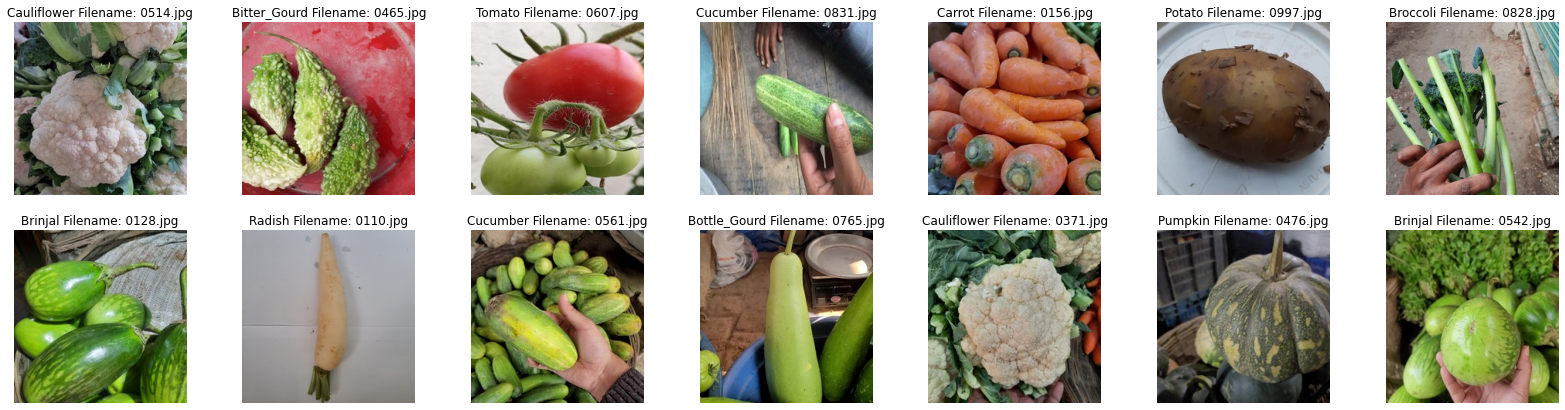

In [15]:
random_images()

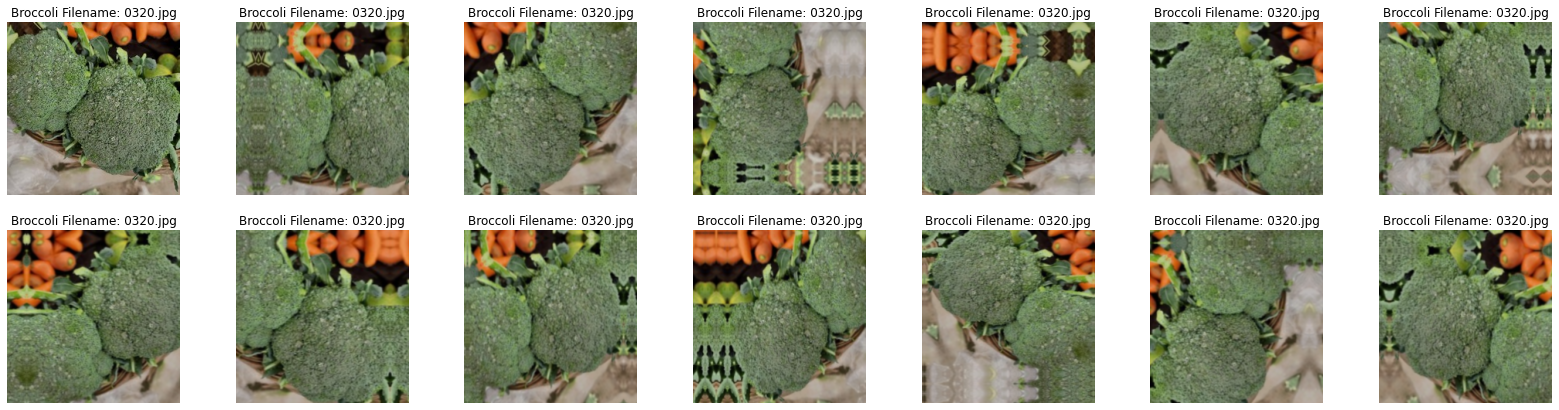

In [16]:
augment_image()

## Data preprocessing

In [17]:
#Rescale
train_datagen = ImageDataGenerator(rescale=1/255.)


# Load data in from directories and turn it into batches

train_data = train_datagen.flow_from_directory(directory=train_dir,
                               batch_size=32,
                               target_size=(224,224),
                               class_mode='categorical',
                               shuffle = True,
                               seed=42)
test_data = train_datagen.flow_from_directory(directory=test_dir,
                               batch_size=32,
                               target_size=(224,224),
                              shuffle = False,
                               class_mode='categorical')
val_data = train_datagen.flow_from_directory(directory=val_dir,
                               batch_size=32,
                               target_size=(224,224),
                                shuffle = False,
                               class_mode='categorical')


Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


## Models

### model_0: Baseline 
this is the model from previous experiments



In [18]:
inputs = layers.Input(shape=(224,224,3))
x = augmentation(inputs)
x = layers.Conv2D(filters = 16, kernel_size= 5, activation = "relu")(x)
x = layers.Conv2D(filters = 32, kernel_size= 3, activation = "relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(filters = 64, kernel_size= 3, activation = "relu")(x)
x = layers.Conv2D(filters = 64, kernel_size= 3, activation = "relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(filters = 256, kernel_size= 3, activation = "relu")(x)
x = layers.Conv2D(filters = 256, kernel_size= 3, activation = "relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(classes), activation = "softmax")(x)

model_0 = tf.keras.Model(inputs, outputs, name="model_0")

model_0.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics="accuracy")

model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentaion_layer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 218, 218, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 64)      1849

In [19]:
model_0, hist_m0 = model_fit(checkpoint_path, model_0)

### model_1: all kernels are set 3

In [20]:
inputs = layers.Input(shape=(224,224,3))
x = augmentation(inputs)
x = layers.Conv2D(filters = 16, kernel_size= 3, activation = "relu")(x)
x = layers.Conv2D(filters = 32, kernel_size= 3, activation = "relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(filters = 64, kernel_size= 3, activation = "relu")(x)
x = layers.Conv2D(filters = 64, kernel_size= 3, activation = "relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(filters = 256, kernel_size= 3, activation = "relu")(x)
x = layers.Conv2D(filters = 256, kernel_size= 3, activation = "relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(classes), activation = "softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1")

model_1.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics="accuracy")

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentaion_layer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 108, 108, 64)      1849

In [21]:
model_1, hist_m1 = model_fit(checkpoint_path, model_1)

### model_2: slightly increase filter count in the middle block

In [22]:
inputs = layers.Input(shape=(224,224,3))
x = augmentation(inputs)
x = layers.Conv2D(filters = 16, kernel_size= 5, activation = "relu")(x)
x = layers.Conv2D(filters = 32, kernel_size= 3, activation = "relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(filters = 64, kernel_size= 3, activation = "relu")(x)
x = layers.Conv2D(filters = 128, kernel_size= 3, activation = "relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(filters = 256, kernel_size= 3, activation = "relu")(x)
x = layers.Conv2D(filters = 256, kernel_size= 3, activation = "relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(classes), activation = "softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2")

model_2.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics="accuracy")

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentaion_layer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 conv2d_13 (Conv2D)          (None, 218, 218, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 109, 109, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 107, 107, 64)      1849

In [23]:
model_2, hist_m2 = model_fit(checkpoint_path, model_2)

### model_3: a clone of model_0 with deeper classifier

In [24]:
clone_0 = tf.keras.models.clone_model(model_0)

In [25]:
clone_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentaion_layer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 218, 218, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 64)      1849

In [26]:
model_3= tf.keras.Sequential(name="model_3")

In [27]:
for lay in clone_0.layers[:-1]:
    model_3.add(lay)

In [28]:
for lay in model_3.layers:
    lay.trainable = False

In [29]:
model_3.add(tf.keras.layers.Dense(32, activation="relu"))
model_3.add(tf.keras.layers.BatchNormalization())
model_3.add(tf.keras.layers.Dense(32, activation="relu"))
model_3.add(tf.keras.layers.BatchNormalization())
model_3.add(tf.keras.layers.Dense(len(classes), activation="softmax"))


In [30]:
model_3.summary()
model_3.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics="accuracy")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentaion_layer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 218, 218, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 105, 105, 64)      3692

In [31]:
model_3, hist_m3 = model_fit(checkpoint_path, model_3, epochs=100)

### model_4: since model_3 was quite a disappointment, I remove one dense layer

In [32]:
model_4= tf.keras.Sequential(name="model_4")

for lay in clone_0.layers[:-1]:
    model_4.add(lay)

for lay in model_4.layers:
    lay.trainable = False
    
model_4.add(tf.keras.layers.Dense(32, activation="relu"))
model_4.add(tf.keras.layers.BatchNormalization())
model_4.add(tf.keras.layers.Dense(len(classes), activation="softmax"))

model_4.summary()
model_4.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics="accuracy")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentaion_layer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 218, 218, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 105, 105, 64)      3692

In [33]:
model_4, hist_m4 = model_fit(checkpoint_path, model_4, epochs=100)

### model_5: 
Since neither model_3 nor model_4 showed a performance even cose to model_0, as a last attempt I try to retrain all layers in model_4. Maybe fitting the classifier together with the feature extraction does improve the result 

In [34]:
model_5= tf.keras.Sequential(name="model_5")

for lay in clone_0.layers[:-1]:
    model_5.add(lay)
    
model_5.add(tf.keras.layers.Dense(32, activation="relu"))
model_5.add(tf.keras.layers.BatchNormalization())
model_5.add(tf.keras.layers.Dense(len(classes), activation="softmax"))

for lay in model_5.layers:
    lay.trainable = True

model_5.summary()
model_5.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics="accuracy")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentaion_layer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 218, 218, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 105, 105, 64)      3692

In [35]:
model_5, hist_m5 = model_fit(checkpoint_path, model_5, epochs=100)

### model 6: using batchnormalization but now correctly
a clone of model_0 with batchnormalization

In [36]:
inputs = tf.keras.layers.Input(shape=(224,224,3))
x = augmentation(inputs)
x = tf.keras.layers.Conv2D(16, kernel_size=5, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(256, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(256, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(len(classes), use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Activation("softmax")(x)

model_6 = tf.keras.Model(inputs, outputs, name="model_6")

model_6.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics="accuracy")

model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentaion_layer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 220, 220, 16)      1200      
                                                                 
 batch_normalization_4 (Batc  (None, 220, 220, 16)     64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 220, 220, 16)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 218, 218, 32)      4608

In [37]:
model_6, hist_m6 = model_fit(checkpoint_path, model_6, epochs=100)

### model 7: a deeper version of model 6

In [38]:
inputs = tf.keras.layers.Input(shape=(224,224,3))
x = augmentation(inputs)
x = tf.keras.layers.Conv2D(16, kernel_size=5, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(128, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(256, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(256, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(512, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(512, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2*len(classes), use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(len(classes), use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Activation("softmax")(x)

model_7 = tf.keras.Model(inputs, outputs, name="model_7")

model_7.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics="accuracy")

model_7.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentaion_layer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 220, 220, 16)      1200      
                                                                 
 batch_normalization_11 (Bat  (None, 220, 220, 16)     64        
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 220, 220, 16)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 218, 218, 32)      4608

In [39]:
model_7, hist_m7 = model_fit(checkpoint_path, model_7, epochs=100)

## Trying to beat model_0 with Transfer Learning

### VGG16: dense layers removed, last conv2d trainable

In [40]:
model_VGG16 = tf.keras.applications.vgg16.VGG16()

In [41]:
print(model_VGG16)

In [42]:
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [43]:
vgg16_feature = tf.keras.Sequential()
vgg16_feature.build(input_shape=(None,224,224,3))
print(vgg16_feature.built)

True


In [44]:
for layer in model_VGG16.layers[1:-4]:
    vgg16_feature.add(layer)

vgg16_feature.build(input_shape=(None,224,224,3))

In [45]:
vgg16_feature.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [46]:
for layers in vgg16_feature.layers[:-2]:
    layers.trainable = False

In [47]:
model_VGG16 = tf.keras.Sequential([
    augmentation,
    vgg16_feature,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(classes), activation="softmax")
], name="model_VGG16")

model_VGG16.build(input_shape=(None, 224,224,3))
print(model_VGG16.built)

True


In [48]:
model_VGG16.summary()

Model: "model_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentaion_layer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 sequential (Sequential)     (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_13 (Dense)            (None, 15)                376335    
                                                                 
Total params: 15,091,023
Trainable params: 2,736,143
Non-trainable params: 12,354,880
_________________________________________________________________


In [49]:
model_VGG16.compile(loss="categorical_crossentropy",
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics="accuracy")

In [50]:
model_VGG16, hist_VGG16 = model_fit(checkpoint_path, model_VGG16)

In [51]:
models = [model_0, model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_VGG16]

## Evaluation

In [52]:
for m in models:
    print(m.name)
    m.evaluate(val_data)
    print()

model_0
94/94 [==============================] - 7s 35ms/step - loss: 0.0203 - accuracy: 0.9950

model_1
94/94 [==============================] - 4s 35ms/step - loss: 0.0325 - accuracy: 0.9930

model_2
94/94 [==============================] - 3s 34ms/step - loss: 0.0179 - accuracy: 0.9957

model_3
94/94 [==============================] - 3s 33ms/step - loss: 0.4557 - accuracy: 0.8483

model_4
94/94 [==============================] - 3s 35ms/step - loss: 0.5452 - accuracy: 0.8257

model_5
94/94 [==============================] - 3s 34ms/step - loss: 0.0258 - accuracy: 0.9933

model_6
94/94 [==============================] - 4s 36ms/step - loss: 0.0069 - accuracy: 0.9987

model_7
94/94 [==============================] - 4s 39ms/step - loss: 0.0037 - accuracy: 0.9997

sequential_11
94/94 [==============================] - 7s 69ms/step - loss: 0.0386 - accuracy: 0.9983



In [53]:
for m in models:
    print(m.name)
    m.evaluate(test_data)
    print()

model_0
94/94 [==============================] - 14s 148ms/step - loss: 0.0200 - accuracy: 0.9967

model_1
94/94 [==============================] - 4s 37ms/step - loss: 0.0342 - accuracy: 0.9927

model_2
94/94 [==============================] - 3s 33ms/step - loss: 0.0321 - accuracy: 0.9950

model_3
94/94 [==============================] - 3s 33ms/step - loss: 0.4739 - accuracy: 0.8353

model_4
94/94 [==============================] - 3s 33ms/step - loss: 0.5588 - accuracy: 0.8173

model_5
94/94 [==============================] - 3s 32ms/step - loss: 0.0240 - accuracy: 0.9937

model_6
94/94 [==============================] - 3s 33ms/step - loss: 0.0151 - accuracy: 0.9973

model_7
94/94 [==============================] - 3s 33ms/step - loss: 0.0085 - accuracy: 0.9973

sequential_11
94/94 [==============================] - 6s 64ms/step - loss: 0.0323 - accuracy: 0.9970



In [57]:
df = my_code.list_mispredicts(model_7, test_data, classes)
df

,image,true,true_prob %,predicted,pred_label,predicted_prob %
0,Bean\0635.jpg,0,6.402588,9,Cucumber,73.583984
1,Bitter_Gourd\1290.jpg,1,30.371094,9,Cucumber,63.574219
2,Bitter_Gourd\1326.jpg,1,1.500702,12,Pumpkin,94.824219
3,Broccoli\1079.jpg,4,16.308594,0,Bean,63.720703
4,Capsicum\1010.jpg,6,45.678711,3,Brinjal,46.948242
5,Capsicum\1102.jpg,6,13.549805,8,Cauliflower,78.710938
6,Capsicum\1191.jpg,6,2.239990,14,Tomato,97.509766
7,Capsicum\1197.jpg,6,44.653320,14,Tomato,55.126953


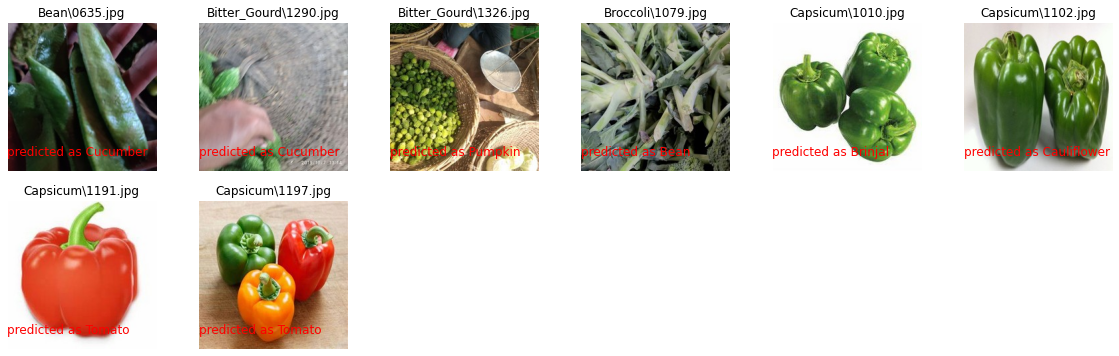

In [58]:
my_code.show_mispredicts(df, test_dir, 0, 8)

In [59]:
df = my_code.list_mispredicts(model_7, val_data, classes)
df

,image,true,true_prob %,predicted,pred_label,predicted_prob %
0,Papaya\1008.jpg,10,5.59082,8,Cauliflower,72.363281


In [62]:
df = my_code.list_mispredicts(model_6, test_data, classes)
df

,image,true,true_prob %,predicted,pred_label,predicted_prob %
0,Bean\0635.jpg,0,0.719070,3,Brinjal,81.201172
1,Bitter_Gourd\1290.jpg,1,15.185547,9,Cucumber,30.102539
2,Bitter_Gourd\1326.jpg,1,8.990479,12,Pumpkin,74.121094
3,Capsicum\1010.jpg,6,2.090454,2,Bottle_Gourd,60.449219
4,Capsicum\1045.jpg,6,22.167969,10,Papaya,70.458984
5,Capsicum\1157.jpg,6,0.437546,10,Papaya,99.414062
6,Carrot\1045.jpg,7,0.139332,12,Pumpkin,99.804688
7,Tomato\1124.jpg,14,41.064453,10,Papaya,53.857422


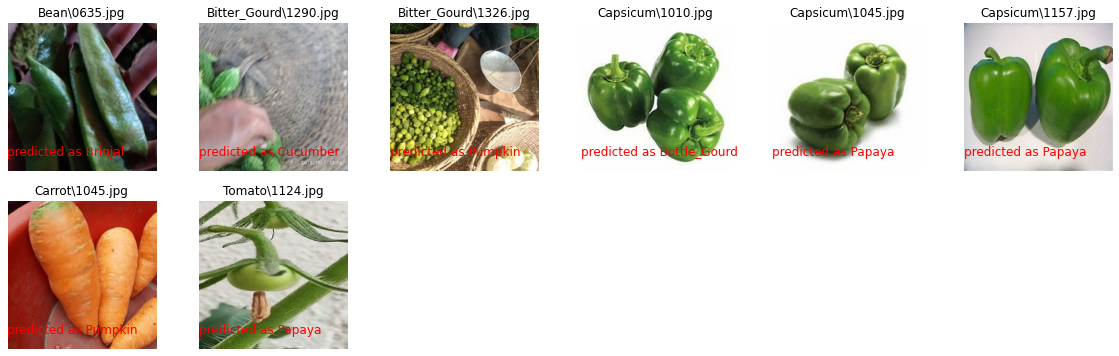

In [63]:
my_code.show_mispredicts(df, test_dir, 0, 8)

In [64]:
df = my_code.list_mispredicts(model_VGG16, test_data, classes)
df

,image,true,true_prob %,predicted,pred_label,predicted_prob %
0,Bean\0635.jpg,0,0.031447,12,Pumpkin,98.095703
1,Bitter_Gourd\1326.jpg,1,0.000119,12,Pumpkin,98.339844
2,Brinjal\1183.jpg,3,0.000012,1,Bitter_Gourd,100.000000
3,Capsicum\1157.jpg,6,0.124454,10,Papaya,99.853516
4,Cauliflower\1081.jpg,8,0.000072,4,Broccoli,100.000000
5,Cauliflower\1093.jpg,8,0.763702,1,Bitter_Gourd,99.218750
6,Cucumber\1034.jpg,9,0.000000,10,Papaya,100.000000
7,Papaya\1322.jpg,10,0.955963,9,Cucumber,99.023438
8,Tomato\1067.jpg,14,10.968018,4,Broccoli,89.013672


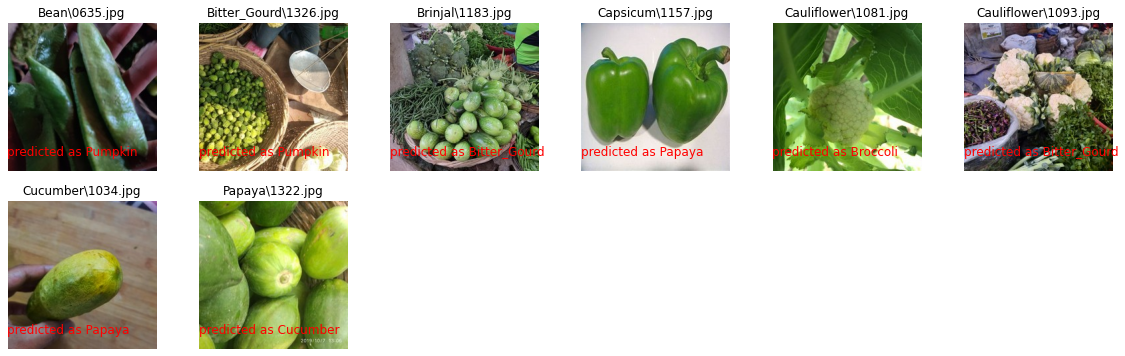

In [65]:
my_code.show_mispredicts(df, test_dir, 0, 8)